# Programming Assignment 1

In [42]:
# Setup and load starter codes
import argparse

import numpy as np

import data
import network

from matplotlib import pyplot as plt

np.random.seed(seed = 100) # fix random seed to make things reproducible

## Loading Data

In [2]:
train_val = data.load_data()
train_val[0].shape, train_val[1].shape

((60000, 784), (60000,))

In [3]:
test = data.load_data(train=False)
test[0].shape, test[1].shape

((10000, 784), (10000,))

## Data EDA

### Training

In [4]:
# Classes distribution
c_counts = np.zeros(10)
for c in train_val[1]:
    c_counts[c] += 1
c_counts

array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
       6000.])

### Test

In [5]:
# Classes distribution
c_counts = np.zeros(10)
for c in test[1]:
    c_counts[c] += 1
c_counts

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000.])

## Logistic Regression

### Pre-process
Get two sets of data for the logistic regression

In [6]:
# filter dataset before start
def set1_filter(dataset):
    # 0 or 6
    idx = []
    img, lab = dataset
    for i in range(len(lab)):
        if lab[i] == 0 or lab[i] == 6:
            idx.append(i)

    return img[idx], lab[idx]

def set2_filter(dataset):
    # 2 or 6
    idx = []
    img, lab = dataset
    for i in range(len(lab)):
        if lab[i] == 2 or lab[i] == 6:
            idx.append(i)

    return img[idx], lab[idx]

In [7]:
train_set1 = set1_filter(train_val)
print(train_set1[0].shape, train_set1[1].shape)
train_set2 = set2_filter(train_val)
print(train_set2[0].shape, train_set2[1].shape)

(12000, 784) (12000,)
(12000, 784) (12000,)


In [8]:
test_set1 = set1_filter(test)
print(test_set1[0].shape, test_set1[1].shape)
test_set2 = set2_filter(test)
print(test_set2[0].shape, test_set2[1].shape)

(2000, 784) (2000,)
(2000, 784) (2000,)


In [9]:
# put data into X and y respectively
train_X_set1, train_y_set1 = train_set1[0], train_set1[1]
train_X_set2, train_y_set2 = train_set2[0], train_set2[1]
test_X_set1, test_y_set1 = test_set1[0], test_set1[1]
test_X_set2, test_y_set2 = test_set2[0], test_set2[1]

In [10]:
# normalize X
train_X_set1 = data.min_max_normalize(train_X_set1)
train_X_set2 = data.min_max_normalize(train_X_set2)
test_X_set1 = data.min_max_normalize(test_X_set1)
test_X_set2 = data.min_max_normalize(test_X_set2)

In [11]:
# change labels for logistic regression
# for set 1, set 6 to be 1, and 0 to be 0
train_y_set1 = np.where(train_y_set1 == 6, 1, train_y_set1)

test_y_set1 = np.where(test_y_set1 == 6, 1, test_y_set1)

# for set 2, set 6 to be 1, and 2 to be 0
train_y_set2 = np.where(train_y_set2 == 6, 1, train_y_set2)
train_y_set2 = np.where(train_y_set2 == 2, 0, train_y_set2)

test_y_set2 = np.where(test_y_set2 == 6, 1, test_y_set2)
test_y_set2 = np.where(test_y_set2 == 2, 0, test_y_set2)

In [12]:
# merge things back
train_val_set1 = (train_X_set1, train_y_set1)
train_val_set2 = (train_X_set2, train_y_set2)
test_set1 = (test_X_set1, test_y_set1)
test_set2 = (test_X_set2, test_y_set2)

### Cross Validation and Test Performance

In [13]:
# training and validation
def cross_validation(dataset, hyperparameters, activation, loss, out_dim):
    regressor = network.Network(hyperparameters, activation, loss, out_dim)

    losses_train = []
    losses_val = []

    accs_val = []

    for train, val in data.generate_k_fold_set(dataset, k=hyperparameters["k_folds"]):
        for epoch in range(hyperparameters["epochs"]):
            train = data.shuffle(train)
            loss_train = [] # training loss per epoch including all mini-batchs
            for minibatch in data.generate_minibatches(train, batch_size=hyperparameters["batch_size"]): # SGD
                loss_batch, _ = regressor.train(minibatch)
                loss_train.append(loss_batch)

            loss_val, acc_val = regressor.test(val) # use the current weight to get a validation loss

            if len(losses_val) != 0 and loss_val > losses_val[-1]: # if the validation loss rise up
                break # early stopping

            loss_train = np.mean(loss_train) # average all mini-batchs
            losses_train.append(loss_train)
            losses_val.append(loss_val)
            accs_val.append(acc_val)

    plt.plot(losses_train)
    plt.plot(losses_val)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss plot")
    plt.legend(["Training Loss", "Validation Loss"])

    return regressor, np.mean(accs_val)

#### Set 1

The average validation accuracy is: 0.9947194444444445
Test loss: 0.03844243458299217
Test accuracy: 0.988


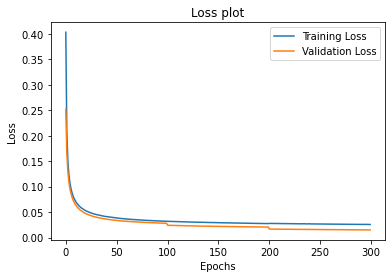

In [14]:
# use the default setting
hyperparameters = {"epochs": 100,
                   "batch_size": 64,
                   "learning_rate": 0.001,
                   "k_folds": 10}

regressor_set1, val_acc_set1 = cross_validation(train_val_set1, hyperparameters, network.softmax, network.multiclass_cross_entropy, 2)
print("The average validation accuracy is:", val_acc_set1)

# test the test set performance
test_loss, test_acc = regressor_set1.test(test_set1)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

The average validation accuracy is: 0.990938888888889
Test loss: 0.046318612373823155
Test accuracy: 0.986


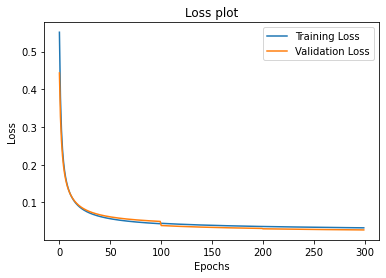

In [15]:
# tuning
hyperparameters = {"epochs": 100,
                   "batch_size": 100,
                   "learning_rate": 0.0005,
                   "k_folds": 10}

regressor_set1, val_acc_set1 = cross_validation(train_val_set1, hyperparameters, network.softmax, network.multiclass_cross_entropy, 2)
print("The average validation accuracy is:", val_acc_set1)

# test the test set performance
test_loss, test_acc = regressor_set1.test(test_set1)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

#### Set 2

The average validation accuracy is: 0.8905202578268875
Test loss: 0.3012482428224823
Test accuracy: 0.8785


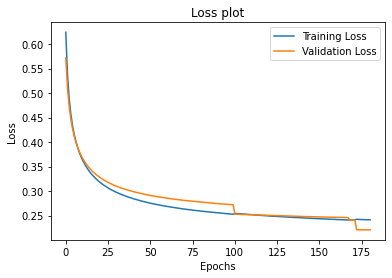

In [16]:
# use the default setting
hyperparameters = {"epochs": 100,
                   "batch_size": 64,
                   "learning_rate": 0.001,
                   "k_folds": 10}

regressor_set2, val_acc_set2 = cross_validation(train_val_set2, hyperparameters, network.softmax, network.multiclass_cross_entropy, 2)
print("The average validation accuracy is:", val_acc_set2)
# test the test set performance
test_loss, test_acc = regressor_set2.test(test_set2)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

The average validation accuracy is: 0.9035986733001659
Test loss: 0.29244014664955525
Test accuracy: 0.884


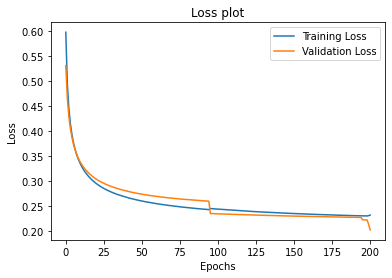

In [39]:
# tuning
hyperparameters = {"epochs": 100,
                   "batch_size": 200,
                   "learning_rate": 0.005,
                   "k_folds": 10}

regressor_set2, val_acc_set2 = cross_validation(train_val_set2, hyperparameters, network.softmax, network.multiclass_cross_entropy, 2)
print("The average validation accuracy is:", val_acc_set2)
# test the test set performance
test_loss, test_acc = regressor_set2.test(test_set2)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

## Softmax Regression

### Pre-process
Since, for this part, we do not need to get specific subset of data, we can directly use the dataset. Just for sure, load the data again.

In [18]:
train_val = data.load_data()
train_val[0].shape, train_val[1].shape

((60000, 784), (60000,))

In [19]:
test = data.load_data(train=False)
test[0].shape, test[1].shape

((10000, 784), (10000,))

#### Normalization

In [20]:
train_val_X, train_val_y = train_val
test_X, test_y = test
# normalize X
train_val_X = data.min_max_normalize(train_val_X)
test_X = data.min_max_normalize(test_X)

train_val = (train_val_X, train_val_y)
test = (test_X, test_y)

### Cross Validation and Test Performance

The average validation accuracy is: 0.8070270935960592
Test loss: 1.0171356329395458
Test accuracy: 0.6926


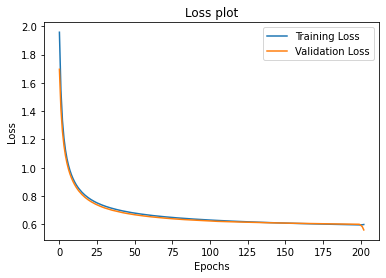

In [21]:
# use the default setting
hyperparameters = {"epochs": 100,
                   "batch_size": 64,
                   "learning_rate": 0.001,
                   "k_folds": 10}

regressor_softmax, val_acc_softmax = cross_validation(train_val, hyperparameters, network.softmax, network.multiclass_cross_entropy, 10)
print("The average validation accuracy is:", val_acc_softmax)

# test the test set performance
test_loss, test_acc = regressor_softmax.test(test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

The average validation accuracy is: 0.7445988888888888
Test loss: 1.2034891928195826
Test accuracy: 0.635


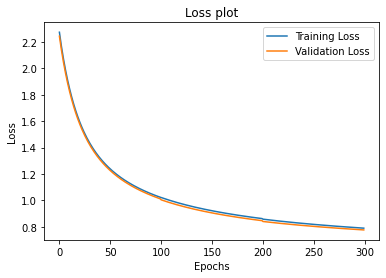

In [63]:
# tuning
hyperparameters = {"epochs": 100,
                   "batch_size": 1000,
                   "learning_rate": 0.001,
                   "k_folds": 10}

regressor_softmax, val_acc_softmax = cross_validation(train_val, hyperparameters, network.softmax, network.multiclass_cross_entropy, 10)
print("The average validation accuracy is:", val_acc_softmax)

# test the test set performance
test_loss, test_acc = regressor_softmax.test(test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

In [65]:
# try different normalization
train_val = data.load_data()
test = data.load_data(train=False)

train_val_X, train_val_y = train_val
test_X, test_y = test
# normalize X
train_val_X = data.z_score_normalize(train_val_X)
test_X = data.z_score_normalize(test_X)

train_val = (train_val_X, train_val_y)
test = (test_X, test_y)

The average validation accuracy is: 0.8121015779092701
Test loss: 1.0047277137790198
Test accuracy: 0.7027


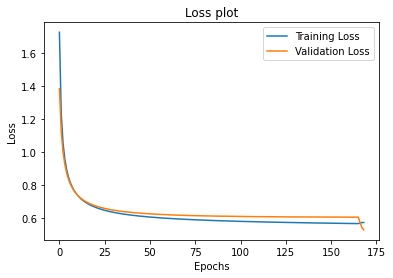

In [70]:
# tuning
hyperparameters = {"epochs": 300,
                   "batch_size": 50,
                   "learning_rate": 0.0002,
                   "k_folds": 10}

regressor_softmax, val_acc_softmax = cross_validation(train_val, hyperparameters, network.softmax, network.multiclass_cross_entropy, 10)
print("The average validation accuracy is:", val_acc_softmax)

# test the test set performance
test_loss, test_acc = regressor_softmax.test(test)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)